# This notebook is to check the best time period for C/10 discharge

In [47]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import random;import time, signal
fs=10;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P2"))
sys.path.append(str_path_1) 
from Fun_P2 import * 
# pb.set_logging_level("INFO")

In [49]:
model = pb.lithium_ion.DFN(
    options={
    "thermal": "lumped",
    "SEI": "interstitial-diffusion limited",
    "SEI on cracks": "true",
    "SEI film resistance": "distributed", 
    "SEI porosity change": "true",
    "particle mechanics": ("swelling and cracking", "swelling only"),
    "loss of active material": "stress-driven",
    "lithium plating": "partially reversible",
    "contact resistance": "true",
    "open-circuit potential": "current sigmoid",
} 
)
param = pb.ParameterValues("OKane2023")
# param.update({"Negative electrode porosity": 0.1}) 
# 0.21289519 for SEI=1.2362e-08 * 2 m  
# and crack length [m]": 2e-08, crack width [m]": 1.5e-08, on both electrode
# Adjust SEI parameters
param.update({"Inner SEI lithium interstitial diffusivity [m2.s-1]": 3e-19})
# Override SEI thickness dependence of lithium plating
param.update({"Dead lithium decay rate [s-1]": 1e-8})
param.update({"Lithium plating kinetic rate constant [m.s-1]": 1e-12})
# Adjust mechanical degradation parameters
param.update({"Negative electrode cracking rate": 1e-20})
param.update({"Negative electrode LAM constant proportional term [s-1]": 1e-19})
param.update({"Positive electrode LAM constant proportional term [s-1]": 1e-19})

c_e = model.variables["Electrolyte concentration [mol.m-3]"]
T = model.variables["Cell temperature [K]"]
D_e = model.param.D_e
kappa_e = model.param.kappa_e
model.variables["Electrolyte diffusivity [m2.s-1]"] = D_e(c_e, T)
model.variables["Electrolyte conductivity [S.m-1]"] = kappa_e(c_e, T)
def Run_C_10(model,param,C_rate, time_period):
    start_1 = pb.Timer() 
    V_max = 4.2;        V_min = 2.5; 
    exp_RPT_text = [ (
        f"Discharge at {C_rate} C until {V_min} V ({time_period} minute period)", #  (1 minute period)  
        "Rest for 1 hours (10 minute period)",  
        f"Charge at {C_rate} C until {V_max} V ({time_period} minute period)",
        "Rest for 1 hours (10 minute period)",
        ) ]
    exp_RPT_refill_text = [ (
        f"Charge at 0.3C until {V_max} V",  
        f"Hold at {V_max}V until C/100",
        "Rest for 1 hours (10 minute period)",  
        ) ]
    Exp_C_10_DC = pb.Experiment( exp_RPT_refill_text*1 +   exp_RPT_text*1 )
    var_pts = {
        "x_n": 5,  # negative electrode
        "x_s": 5,  # separator 
        "x_p": 5,  # positive electrode
        "r_n": 60,  # negative particle
        "r_p": 30,  # positive particle
    }
    sim_C_10 = pb.Simulation(
        model, 
        experiment=Exp_C_10_DC,
        parameter_values=param,
        solver=pb.CasadiSolver(return_solution_if_failed_early=True),
        var_pts=var_pts, )
    sol_C_10 = sim_C_10.solve()
    print(f'running time: for {time_period} minute period is {start_1.time()}')
    return sol_C_10


In [50]:
def Run_Rest(model,param,C_rate, time_period):
    start_1 = pb.Timer() 
    V_max = 4.2;        V_min = 2.5; 
    exp_RPT_refill_text = [ (
        f"Charge at 0.3C until {V_max} V",  
        f"Hold at {V_max}V until C/100",
        f"Rest for 3 hours ({time_period} minute period)",  
        ) ]
    Exp = pb.Experiment( exp_RPT_refill_text*1 )
    var_pts = {
        "x_n": 5,  # negative electrode
        "x_s": 5,  # separator 
        "x_p": 5,  # positive electrode
        "r_n": 60,  # negative particle
        "r_p": 30,  # positive particle
    }
    sim = pb.Simulation(
        model, 
        experiment=Exp,
        parameter_values=param,
        solver=pb.CasadiSolver(return_solution_if_failed_early=True),
        var_pts=var_pts, )
    sol = sim.solve()
    print(f'running time: for {time_period} minute period is {start_1.time()}')
    return sol
Rest_Time_periods = [5,10,20,30,60,]  #
Sol_Rest = []
for time_period in Rest_Time_periods:
    Sol_Rest.append(Run_Rest(model,param,0.1,time_period))

running time: for 5 minute period is 14.332 s
running time: for 10 minute period is 9.555 s
running time: for 20 minute period is 8.131 s
running time: for 30 minute period is 7.917 s
running time: for 60 minute period is 7.411 s


In [44]:
print(Sol_Rest[0]["Negative electrode porosity"].entries[:,0])
print(Sol_Rest[0]["Total SEI on cracks thickness [m]"].entries[:,0])
print(Sol_Rest[0]["Lithium plating thickness [m]"].entries[:,0])

[0.21289519 0.21289519 0.21289519 0.21289519 0.21289519]
[2.4724e-12 2.4724e-12 2.4724e-12 2.4724e-12 2.4724e-12]
[0. 0. 0. 0. 0.]


In [54]:
#model.variables.search("thickness [m]")
list_short = []
for var, equation in model.initial_conditions.items():
    print(var._name)
    list_short.append(var._name)

Discharge capacity [A.h]
Throughput capacity [A.h]
Negative particle crack length [m]
Negative electrode active material volume fraction
Loss of lithium due to loss of active material in negative electrode [mol]
Positive electrode active material volume fraction
Loss of lithium due to loss of active material in positive electrode [mol]
Total negative electrode interfacial current density variable [A.m-2]
Total positive electrode interfacial current density variable [A.m-2]
Negative particle concentration [mol.m-3]
Positive particle concentration [mol.m-3]
Negative electrode potential [V]
Positive electrode potential [V]
Porosity times concentration [mol.m-3]
Electrolyte potential [V]
Volume-averaged cell temperature [K]
Inner SEI thickness [m]
Outer SEI thickness [m]
Inner SEI on cracks thickness [m]
Outer SEI on cracks thickness [m]
Lithium plating concentration [mol.m-3]
Dead lithium concentration [mol.m-3]


In [46]:
Sol_Rest[0]["Electrolyte concentration [mol.m-3]"].entries[:,0]

array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000.])

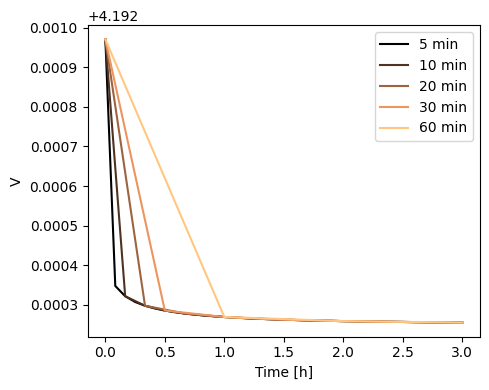

In [51]:
fig, ax = plt.subplots( figsize=(5,4),tight_layout=True)
copper = mpl.cm.get_cmap("copper", len(Sol_Rest))  
for i,sol in enumerate(Sol_Rest):
    step = 2; cycle = 0
    ax.plot(
        sol.cycles[cycle].steps[step]["Time [h]"].entries-sol.cycles[cycle].steps[step]["Time [h]"].entries[0],
        sol.cycles[cycle].steps[step]["Terminal voltage [V]"].entries,
        color=copper(i),
        label=f"{Rest_Time_periods[i]} min")
ax.set_xlabel("Time [h]")
ax.set_ylabel('V')
ax.legend()
#ax.set_ylim(4.06,4.21)
#ax.set_xlim(8.25,9.75)

In [9]:
Time_periods = [1,5,10,20,30,40,60]
Sol = []
for time_period in Time_periods:
    Sol.append(Run_C_10(model,param,0.1,time_period))


running time: for 1 minute period is 1 minute, 1 second
running time: for 5 minute period is 1 minute, 27 seconds
running time: for 10 minute period is 59.515 s


At t = 702.221 and h = 3.20544e-10, the corrector convergence failed repeatedly or with |h| = hmin.


running time: for 20 minute period is 53.706 s


At t = 1302.23 and h = 1.33014e-10, the corrector convergence failed repeatedly or with |h| = hmin.


running time: for 30 minute period is 45.021 s


At t = 1902.23 and h = 3.37806e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 690.224 and h = 2.06375e-10, the corrector convergence failed repeatedly or with |h| = hmin.


running time: for 40 minute period is 49.549 s


At t = 3102.22 and h = 2.04989e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1284.23 and h = 1.89175e-10, the corrector convergence failed repeatedly or with |h| = hmin.


running time: for 60 minute period is 48.323 s


(8.25, 9.75)

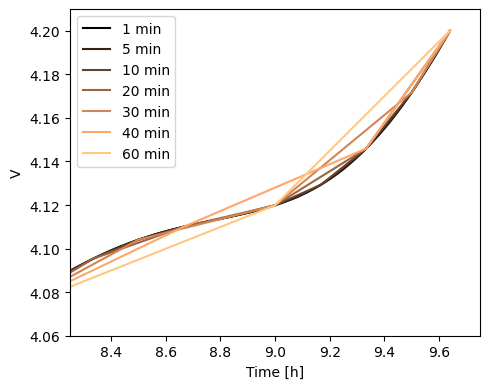

In [34]:
fig, ax = plt.subplots( figsize=(5,4),tight_layout=True)
copper = mpl.cm.get_cmap("copper", len(Sol))  
Time_periods = [1,5,10,20,30,40,60]
for i,sol in enumerate(Sol):
    step = 2
    ax.plot(
        sol.cycles[1].steps[step]["Time [h]"].entries-sol.cycles[1].steps[step]["Time [h]"].entries[0],
        sol.cycles[1].steps[step]["Terminal voltage [V]"].entries,
        color=copper(i),
        label=f"{Time_periods[i]} min")
ax.set_xlabel("Time [h]")
ax.set_ylabel('V')
ax.legend()
ax.set_ylim(4.06,4.21)
ax.set_xlim(8.25,9.75)

(9.25, 9.8)

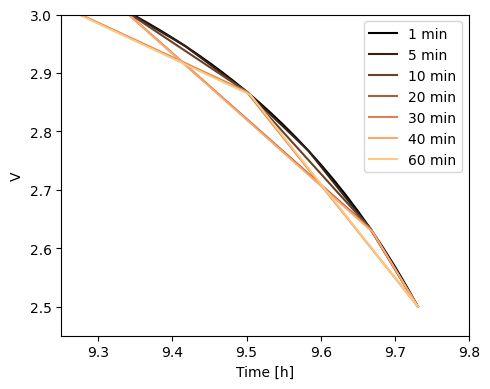

In [40]:
fig, ax = plt.subplots( figsize=(5,4),tight_layout=True)
copper = mpl.cm.get_cmap("copper", len(Sol))  
Time_periods_C_10 = [1,5,10,20,30,40,60]
for i,sol in enumerate(Sol):
    step = 0
    ax.plot(
        sol.cycles[1].steps[step]["Time [h]"].entries-sol.cycles[1].steps[step]["Time [h]"].entries[0],
        sol.cycles[1].steps[step]["Terminal voltage [V]"].entries,
        color=copper(i),
        label=f"{Time_periods_C_10[i]} min")
ax.set_xlabel("Time [h]")
ax.set_ylabel('V')
ax.legend()
ax.set_ylim(2.45,3.0)
ax.set_xlim(9.25,9.8)

In [20]:
Time_periods_0P5C = [0.5, 1,3,4,6,12]
Sol_0p5C = []
for time_period in Time_periods_0P5C:
    Sol_0p5C.append(Run_C_10(model,param,0.5,time_period))

running time: for 0.5 minute period is 1 minute, 3 seconds


At t = 334.307 and h = 9.00638e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 94.3066 and h = 2.29135e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 94.3065 and h = 3.02703e-11, the corrector convergence failed repeatedly or with |h| = hmin.


running time: for 1 minute period is 1 minute, 12 seconds


At t = 394.307 and h = 2.23794e-11, the corrector convergence failed repeatedly or with |h| = hmin.


running time: for 3 minute period is 1 minute, 5 seconds


At t = 154.307 and h = 2.43451e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 154.305 and h = 2.12866e-15, the corrector convergence failed repeatedly or with |h| = hmin.


running time: for 4 minute period is 1 minute, 4 seconds
running time: for 6 minute period is 57.247 s


At t = 394.307 and h = 1.81796e-11, the corrector convergence failed repeatedly or with |h| = hmin.


running time: for 12 minute period is 59.220 s


Total data points:  450
Applied current [A]: 2.5
Total data points:  234
Applied current [A]: 2.5
Total data points:  89
Applied current [A]: 2.5
Total data points:  71
Applied current [A]: 2.5
Total data points:  53
Applied current [A]: 2.5
Total data points:  35
Applied current [A]: 2.5


Text(0, 0.5, 'Resistance (m$\\Omega$)')

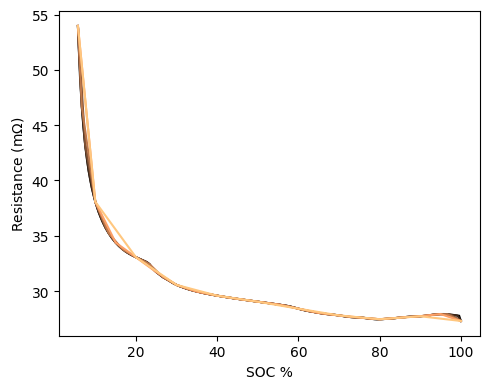

In [45]:
def Get_R_from_Constant_Discharge(sol_C_2,cyc_no,cap_full):
    print("Total data points: ",len(sol_C_2.cycles[1]["Time [h]"].entries))
    cycle = sol_C_2.cycles[cyc_no]
    Dis_Cap = abs(
        cycle.steps[0]["Discharge capacity [A.h]"].entries[0] 
        - cycle.steps[0]["Discharge capacity [A.h]"].entries )
    SOC_CD = (1-Dis_Cap/cap_full)*100
    #print(SOC_CD)
    V_ohmic = (
    cycle.steps[0]['Battery open-circuit voltage [V]'].entries 
    - cycle.steps[0]["Terminal voltage [V]"].entries

    + cycle.steps[0]["Battery particle concentration overpotential [V]"].entries 
    + cycle.steps[0]["X-averaged battery concentration overpotential [V]" ].entries
    #+ cycle.steps[0]["X-averaged battery reaction overpotential [V]" ].entries
    )#
    print("Applied current [A]:",cycle.steps[0]["Current [A]"].entries[0])
    Rohmic_CD = V_ohmic/cycle.steps[0]["Current [A]"].entries[0] * 1e3
    """ fig, ax = plt.subplots( figsize=(5,4),tight_layout=True)
    ax.plot(SOC_CD,Rohmic_CD,label="add")
    ax.set_xlabel("SOC %")
    ax.set_ylabel(r'R (m$\Omega$)')
    ax.legend() """
    return SOC_CD,Rohmic_CD
SOC_CD_0p5C=[];Rohmic_CD_0p5C=[]
Time_periods_0P5C = [0.5, 1,3,4,6,12]
fig, ax = plt.subplots( figsize=(5,4),tight_layout=True)
for i,sol in enumerate(Sol_0p5C):
    SOC_CD,Rohmic_CD=Get_R_from_Constant_Discharge(sol,cyc_no=1,cap_full=5)
    ax.plot(
        SOC_CD,
        Rohmic_CD,
        color=copper(i),
        label=f"{Time_periods_0P5C[i]} min")
ax.set_xlabel("SOC %")
ax.set_ylabel(r'Resistance (m$\Omega$)')


Total data points:  1179
Applied current [A]: 0.5
Total data points:  249
Applied current [A]: 0.5
Total data points:  133
Applied current [A]: 0.5
Total data points:  75
Applied current [A]: 0.5
Total data points:  56
Applied current [A]: 0.5
Total data points:  47
Applied current [A]: 0.5
Total data points:  37
Applied current [A]: 0.5


Text(0, 0.5, 'Resistance (m$\\Omega$)')

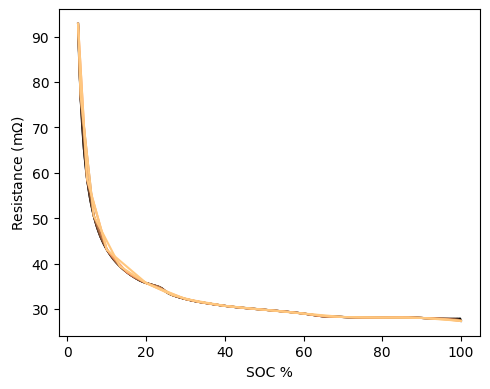

In [47]:
SOC_CD_0p1C=[];Rohmic_CD_0p1C=[]
Time_periods_C_10 = [1,5,10,20,30,40,60]
fig, ax = plt.subplots( figsize=(5,4),tight_layout=True)
for i,sol in enumerate(Sol):
    SOC_CD,Rohmic_CD=Get_R_from_Constant_Discharge(sol,cyc_no=1,cap_full=5)
    ax.plot(
        SOC_CD,
        Rohmic_CD,
        color=copper(i),
        label=f"{Time_periods_C_10[i]} min")
ax.set_xlabel("SOC %")
ax.set_ylabel(r'Resistance (m$\Omega$)')

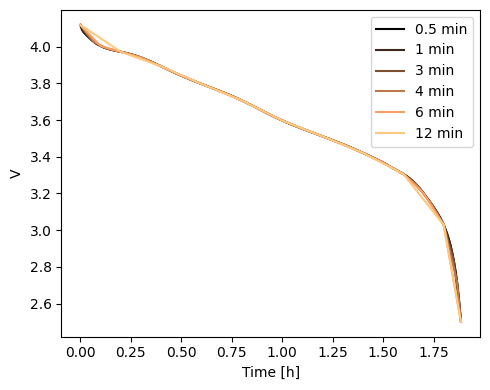

In [41]:
fig, ax = plt.subplots( figsize=(5,4),tight_layout=True)
copper = mpl.cm.get_cmap("copper", len(Sol_0p5C))  
Time_periods = [0.5, 1,3,4,6,12]
for i,sol in enumerate(Sol_0p5C):
    step = 0
    ax.plot(
        sol.cycles[1].steps[step]["Time [h]"].entries-sol.cycles[1].steps[step]["Time [h]"].entries[0],
        sol.cycles[1].steps[step]["Terminal voltage [V]"].entries,
        color=copper(i),
        label=f"{Time_periods[i]} min")
ax.set_xlabel("Time [h]")
ax.set_ylabel('V')
ax.legend()
#ax.set_ylim(2.45,3.0)
#ax.set_xlim(9.25,9.8)

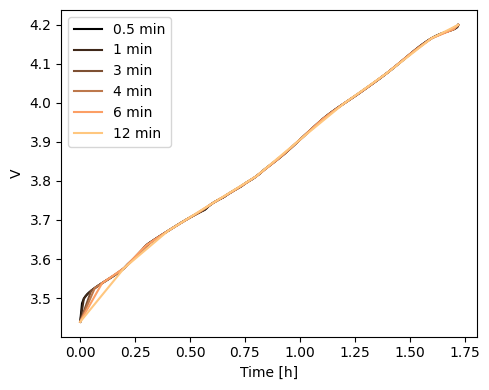

In [42]:
fig, ax = plt.subplots( figsize=(5,4),tight_layout=True)
copper = mpl.cm.get_cmap("copper", len(Sol_0p5C))  
Time_periods = [0.5, 1,3,4,6,12]
for i,sol in enumerate(Sol_0p5C):
    step = 2
    ax.plot(
        sol.cycles[1].steps[step]["Time [h]"].entries-sol.cycles[1].steps[step]["Time [h]"].entries[0],
        sol.cycles[1].steps[step]["Terminal voltage [V]"].entries,
        color=copper(i),
        label=f"{Time_periods[i]} min")
ax.set_xlabel("Time [h]")
ax.set_ylabel('V')
ax.legend()
#ax.set_ylim(2.45,3.0)
#ax.set_xlim(9.25,9.8)